In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# ============================================================
# 1. LOAD RAW GEMSTAT PFAS DATA
# ============================================================
df = pd.read_csv("data/PFAS.csv", encoding="latin1", sep=";")

# Rename columns for convenience
df = df.rename(columns={
    "GEMS.Station.Number": "Station",
    "Sample.Date": "SampleDate",
    "Parameter.Code": "Parameter",
    "Value": "Value"
})

# Keep PFOS only
pfos = df[df["Parameter"].str.contains("PFOS", case=False, na=False)].copy()

# Fix types
pfos["SampleDate"] = pd.to_datetime(pfos["SampleDate"], errors="coerce")
pfos["Value"] = pd.to_numeric(pfos["Value"], errors="coerce")

# Drop invalid values
pfos = pfos.dropna(subset=["SampleDate", "Value"])

# Extract year
pfos["Year"] = pfos["SampleDate"].dt.year

# ============================================================
# 2. SUMMARY TABLE (mean, min, max per station-year)
# ============================================================
summary = (
    pfos.groupby(["Station", "Year"])["Value"]
    .agg(["mean", "min", "max"])
    .reset_index()
)

# ============================================================
# 3. SAVE OUTPUT FILES
# ============================================================
out_dir = "output"
os.makedirs(out_dir, exist_ok=True)

summary_file = os.path.join(out_dir, "PFOS_summary.csv")
timeseries_file = os.path.join(out_dir, "PFOS_timeseries_clean.csv")

summary.to_csv(summary_file, index=False)
pfos.to_csv(timeseries_file, index=False)

print("Saved:")
print(" -", summary_file)
print(" -", timeseries_file)

# ============================================================
# 4. PLOT TIME SERIES (One graph per station)
# ============================================================
plot_dir = "output/plots"
os.makedirs(plot_dir, exist_ok=True)

for station, df_station in pfos.groupby("Station"):
    df_station = df_station.sort_values("SampleDate")

    plt.figure(figsize=(10, 5))
    plt.plot(df_station["SampleDate"], df_station["Value"], marker='o')
    plt.title(f"PFOS Time Series – {station}")
    plt.xlabel("Date")
    plt.ylabel("PFOS Concentration (µg/L)")
    plt.grid(True)

    # Save plot
    filename = os.path.join(plot_dir, f"{station}_PFOS_timeseries.png")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

    print("Saved plot:", filename)

# ============================================================
# 5. OPTIONAL: COMBINED TIME SERIES (all stations)
# ============================================================
plt.figure(figsize=(12, 6))
for station, df_station in pfos.groupby("Station"):
    plt.plot(df_station["SampleDate"], df_station["Value"], label=station)

plt.title("PFOS Time Series – All Stations")
plt.xlabel("Date")
plt.ylabel("PFOS (µg/L)")
plt.legend(loc="upper right", fontsize=6)
plt.grid(True)

combined_plot = os.path.join(plot_dir, "All_Stations_PFOS_timeseries.png")
plt.savefig(combined_plot, dpi=300, bbox_inches="tight")
plt.close()

print("Saved combined plot:", combined_plot)


Saved:
 - output\PFOS_summary.csv
 - output\PFOS_timeseries_clean.csv
Saved plot: output/plots\BEL00081_PFOS_timeseries.png
Saved plot: output/plots\BEL00082_PFOS_timeseries.png
Saved plot: output/plots\BEL00084_PFOS_timeseries.png
Saved plot: output/plots\BEL00086_PFOS_timeseries.png
Saved plot: output/plots\BEL00087_PFOS_timeseries.png
Saved plot: output/plots\BEL00088_PFOS_timeseries.png
Saved plot: output/plots\BEL00090_PFOS_timeseries.png
Saved plot: output/plots\BEL00092_PFOS_timeseries.png
Saved plot: output/plots\BEL00093_PFOS_timeseries.png
Saved plot: output/plots\BEL00094_PFOS_timeseries.png
Saved plot: output/plots\BEL00096_PFOS_timeseries.png
Saved plot: output/plots\BEL00098_PFOS_timeseries.png
Saved plot: output/plots\BEL00100_PFOS_timeseries.png
Saved plot: output/plots\BEL00101_PFOS_timeseries.png
Saved plot: output/plots\BEL00102_PFOS_timeseries.png
Saved plot: output/plots\BEL00104_PFOS_timeseries.png
Saved plot: output/plots\BEL00106_PFOS_timeseries.png
Saved plot: 

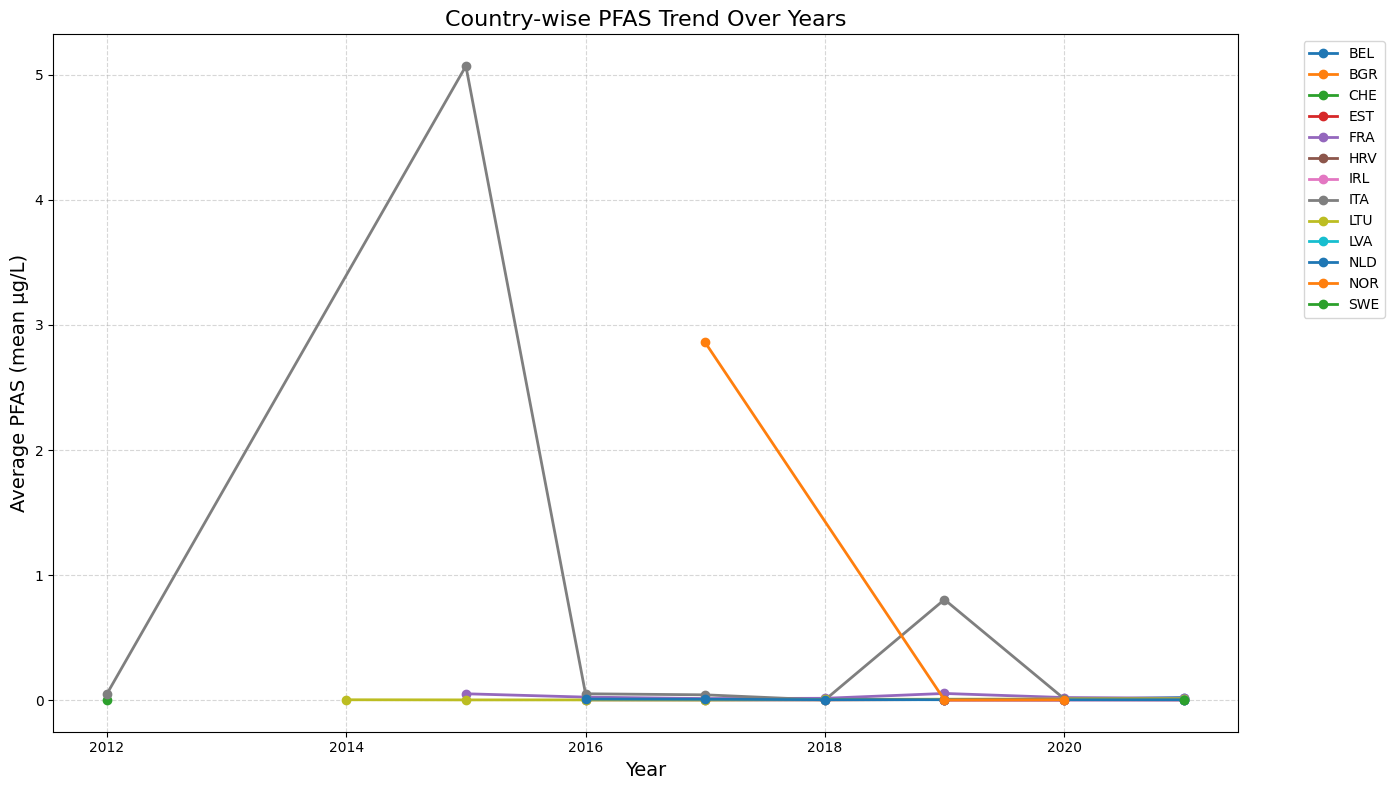

Saved: PFAS_country_year_trend.csv


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ====== Load data ======
df = pd.read_csv("output/PFOS_summary.csv")

# Ensure columns exist
required_cols = ["Station", "Year", "mean"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing column: {c}")

# ====== Extract country from station code ======
df["Country"] = df["Station"].str[:3]

# Convert Year to numeric (if needed)
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.dropna(subset=["Year"])

# ====== Group by country & year ======
country_year = (
    df.groupby(["Country", "Year"])["mean"]
      .mean()
      .reset_index()
      .sort_values(["Country", "Year"])
)

# ====== Plot ======
plt.figure(figsize=(14, 8))

for country in country_year["Country"].unique():
    sub = country_year[country_year["Country"] == country]
    plt.plot(sub["Year"], sub["mean"], marker='o', linewidth=2, label=country)

plt.title("Country-wise PFAS Trend Over Years", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average PFAS (mean µg/L)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

# ====== Save aggregated data ======
country_year.to_csv("PFAS_country_year_trend.csv", index=False)
print("Saved: PFAS_country_year_trend.csv")
